In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np

random.seed(33)

unique_name = "TT_" + "BERT_Finetuned_M"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr2_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [3]:
phemernr2 = pd.read_csv("../../data/processed/phemernr2_dataset_with_tvt.csv", lineterminator="\n")
phemernr2.head()

,tweet_id,tweet_text,label,label2,topic,tvt,cv_fold,tt
0,552833795142209536,The East London Mosque would like to offer its...,non-rumours,non-rumours,charliehebdo-all-rnr-threads,test,2,test
1,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,rumours,true,germanwings-crash-all-rnr-threads,training,3,training
2,552798891994009601,Reports that two of the dead in the #CharlieHe...,rumours,true,charliehebdo-all-rnr-threads,test,2,test
3,576790814942236672,After #Putin disappeared Russian TV no longer ...,non-rumours,non-rumours,putinmissing-all-rnr-threads,test,2,test
4,499678822598340608,Saw #Ferguson for myself. #justiceformichaelbr...,non-rumours,non-rumours,ferguson-all-rnr-threads,training,3,training


In [4]:
labels = []
for i, p2 in phemernr2.iterrows():
    if p2['label'] == 'rumours':
        labels.append([0])
    elif p2['label'] == 'non-rumours':
        labels.append([1])
    else:
        labels.append(None)
labels[:10]

[[1], [0], [0], [1], [1], [1], [1], [0], [1], [1]]

In [5]:
train_vectors = np.array([vectors[i] for i, p2 in phemernr2.iterrows() if p2['tt'] == 'training'])
test_vectors = np.array([vectors[i] for i, p2 in phemernr2.iterrows() if p2['tt'] == 'test'])

train_labels = np.array([labels[i] for i, p2 in phemernr2.iterrows() if p2['tt'] == 'training'])
test_labels = np.array([labels[i] for i, p2 in phemernr2.iterrows() if p2['tt'] == 'test'])

In [6]:
label_tag = ['rumours', 'non-rumours']
label_tag

['rumours', 'non-rumours']

In [7]:
print(train_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(test_labels.shape)

(4500, 768)
(1925, 768)
(4500, 1)
(1925, 1)


In [8]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([1703, 2797]))
(array([0, 1]), array([ 699, 1226]))


In [9]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Linear(128, n_output),
            nn.Sigmoid()
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                
                preds = self.predict(test_x)
                conf_mat = ConfusionMatrix(
                    labels=test_y,
                    predictions=[p[0] for p in preds.cpu().numpy()],
                    binary=True
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.Tensor(input_x))

In [10]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from library.classification import SKLearnClassification
from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr"

logres_model = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr', max_iter=10000)
neigh = KNeighborsClassifier(n_neighbors=3)
svm = LinearSVC()

models = [
    SKLearnClassification(logres_model, "Logistic Regression"),
    SKLearnClassification(neigh, "K-Nearest Neighbor"),
    SKLearnClassification(svm, "Support Vector Machine"),
]
for model in models:
    print(f"\n--- {model.model_name.upper()} ---")
    model.train(train_vectors, train_labels, dataset_name)
    
    print("Test Set")
    preds = model.predict(test_vectors)

    conf_mat = ConfusionMatrix(
        labels=test_labels,
        predictions=preds,
        binary=True
    )
    conf_mat.evaluate()

    print("--- END ---\n")


--- LOGISTIC REGRESSION ---


/media/storage/Work/DataScience/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


---> execution time : 1.63 seconds
Test Set
Binary Class Evaluation

True Positive : 1179
False Positive : 45
False Negative : 47
True Negative : 654

Class positive Evaluation
- Precision : 96.324 %
- Recall : 96.166 %
- F1 : 0.96245

Class negative Evaluation
- Precision : 93.295 %
- Recall : 93.562 %
- F1 : 0.93429

Combined Evaluation
- Accuracy : 95.221 %
- Precision : 94.809 %
- Recall : 94.864 %
- F1 : 0.94836
- Average Confidence : 100.0 %
Model, Combined,,,,positive,,,negative,,,
Anonymous, 95.221, 94.809, 94.864, 0.94836, 96.324, 96.166, 0.96245, 93.295, 93.562, 0.93429, 
--- END ---


--- K-NEAREST NEIGHBOR ---
---> execution time : 0.0 seconds
Test Set


/media/storage/Work/DataScience/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Binary Class Evaluation

True Positive : 1189
False Positive : 40
False Negative : 37
True Negative : 659

Class positive Evaluation
- Precision : 96.745 %
- Recall : 96.982 %
- F1 : 0.96864

Class negative Evaluation
- Precision : 94.684 %
- Recall : 94.278 %
- F1 : 0.9448

Combined Evaluation
- Accuracy : 96.0 %
- Precision : 95.715 %
- Recall : 95.63 %
- F1 : 0.95672
- Average Confidence : 100.0 %
Model, Combined,,,,positive,,,negative,,,
Anonymous, 96.0, 95.715, 95.63, 0.95672, 96.745, 96.982, 0.96864, 94.684, 94.278, 0.9448, 
--- END ---


--- SUPPORT VECTOR MACHINE ---


/media/storage/Work/DataScience/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


---> execution time : 2.19 seconds
Test Set
Binary Class Evaluation

True Positive : 1171
False Positive : 59
False Negative : 55
True Negative : 640

Class positive Evaluation
- Precision : 95.203 %
- Recall : 95.514 %
- F1 : 0.95358

Class negative Evaluation
- Precision : 92.086 %
- Recall : 91.559 %
- F1 : 0.91822

Combined Evaluation
- Accuracy : 94.078 %
- Precision : 93.645 %
- Recall : 93.537 %
- F1 : 0.93591
- Average Confidence : 100.0 %
Model, Combined,,,,positive,,,negative,,,
Anonymous, 94.078, 93.645, 93.537, 0.93591, 95.203, 95.514, 0.95358, 92.086, 91.559, 0.91822, 
--- END ---



/media/storage/Work/DataScience/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 95.792
Saving after new best accuracy : 96.104
Saving after new best accuracy : 96.208
Saving after new best accuracy : 96.26
Saving after new best accuracy : 96.416
Saving after new best accuracy : 96.468
-- Epoch 50, Train Loss : 1.103175438940525, Test Loss : 0.16209563612937927
-- Epoch 100, Train Loss : 0.2621596026001498, Test Loss : 0.3080274760723114
-- Epoch 150, Train Loss : 0.1640602854313329, Test Loss : 0.4337005317211151
-- Epoch 200, Train Loss : 19.826052665244788, Test Loss : 1.5851019620895386
-- Epoch 250, Train Loss : 0.23820039723068476, Test Loss : 0.3563900589942932
-- Epoch 300, Train Loss : 0.05334027562639676, Test Loss : 0.5179547071456909
-- Epoch 350, Train Loss : 0.0756923646258656, Test Loss : 0.3780054450035095
-- Epoch 400, Train Loss : 0.007484805363674241, Test Loss : 0.5975538492202759
-- Epoch 450, Train Loss : 0.0071676367424515774, Test Loss : 0.6712

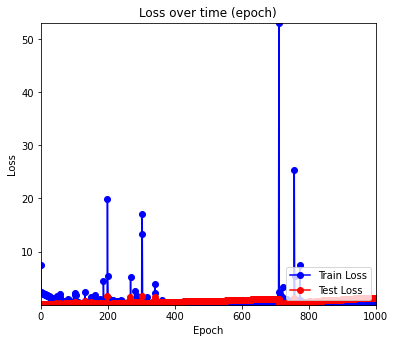


Test Set
Predictions : torch.Size([1925, 1])
Binary Class Evaluation

True Positive : 1195
False Positive : 37
False Negative : 31
True Negative : 662

Class positive Evaluation
- Precision : 96.997 %
- Recall : 97.471 %
- F1 : 0.97234

Class negative Evaluation
- Precision : 95.527 %
- Recall : 94.707 %
- F1 : 0.95115

Combined Evaluation
- Accuracy : 96.468 %
- Precision : 96.262 %
- Recall : 96.089 %
- F1 : 0.96175
- Average Confidence : 94.06 %
Model, Combined,,,,positive,,,negative,,,
Anonymous, 96.468, 96.262, 96.089, 0.96175, 96.997, 97.471, 0.97234, 95.527, 94.707, 0.95115, 


In [11]:
print("Multiclass Classification using 4-Layer Linear Network")
model_name = f"Phemernr2_4LayerNet_{unique_name}"
model = NNClassifier(train_vectors.shape[1], criterion=nn.BCELoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(test_vectors),
                torch.Tensor(test_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=256)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True
)
conf_mat.evaluate()